# Figure 3: MPRA heterogeneity

**Description:** Process data and prepare ready-to-use resources for plotting Figure 1 and Supplemental Figures 1-3

&rarr; Run this notebook with the `tf-train` kernel


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

Using TensorFlow backend.


## IMPORTS AND SETUP

In [4]:
import utilities
from utilities import preprocessing, sequence, model_builder, classification_cleavage, motifs, relative_strength, genomic_context, genetics

from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import test_proportions_2indep


In [5]:
PROJECT = "/projects/b1080/eks/polyadenylation"
DATADIR = os.path.join(PROJECT, "manuscripts", "01_development", "data")
RESDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "analysis", "resources")
OUTDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "figures", "Figure_03")
os.makedirs(OUTDIR, exist_ok = True)


#### Define motif families

In [6]:
all_hexamers = ["".join(x) for x in list(itertools.product('ACGT', repeat = 6))]
all_data = pd.DataFrame.from_dict({'hexamer' : all_hexamers}, orient = 'columns')

with open(os.path.join(RESDIR, 'motif_list_negative.median_then_mean.cutoff_background.pickle'), mode = 'rb') as handle:
    final_background_list = pickle.load(handle)
    
print(len(final_background_list))


2322


In [7]:
variants_patterns = ['TATAAA', 'AGTAAA', 'TTTAAA', 'AATACA', 'CATAAA', 'GATAAA', 'AATATA', 'AATGAA', 'AAGAAA']

a_patterns = ['AAAAAA','AAAAA[C|G|T]','AAAA[C|G|T]A','AAA[C|G|T]AA','AA[C|G|T]AAA','A[C|G|T]AAAA']
t_patterns = ['TTTTTT','TTTTT[A|C|G]','TTTT[A|C|G]T','TTT[A|C|G]TT','TT[A|C|G]TTT','T[A|C|G]TTTT']
g_patterns = ['GGGGGG','GGGGG[A|C|T]','GGGG[A|C|T]G','GGG[A|C|T]GG','GG[A|C|T]GGG','G[A|C|T]GGGG']

pas = [x for x in ['AATAAA','ATTAAA']+variants_patterns if x in final_background_list]
variants = [x for x in variants_patterns if x in final_background_list]
a_rich = list(set([x for x in final_background_list if (re.search("|".join(a_patterns), x) is not None) and (x not in ['AATAAA','ATTAAA'])]))
t_rich = list(set([x for x in final_background_list if (re.search("|".join(t_patterns), x) is not None)]))
g_rich = list(set([x for x in final_background_list if (re.search("|".join(g_patterns), x) is not None)]))

gt_patterns = ['GTGT','TGTG','GTCT','CTGT','TCTG','TGTC']
gt_rich = list(set([x for x in final_background_list for gt in gt_patterns if (gt in x) and ("TGTA" not in x) and ((x.count("T") >= 3) or (x.count("G") >= 3) or (x.count("C") >= 3))]))

tgta_rich = list(set([x for x in final_background_list if ("TGTA" in x)]))


In [8]:
affected_motif_dict = {}

for motiflist,motiflabel in zip([g_rich, gt_rich, tgta_rich, t_rich, a_rich, variants],
                                ['G-Rich', 'GT/CT-Rich', 'TGTA-Rich', 'T-Rich', 'A-Rich', 'PAS Variant']):
    for _ in motiflist:
        affected_motif_dict[_] = motiflabel
        
affected_motif_dict['AATAAA'] = 'AATAAA'
affected_motif_dict['ATTAAA'] = 'ATTAAA'
affected_motif_dict['TGTA'] = 'TGTA'


In [9]:
direction_priority = {
    'created'   : 0,
    'disrupted' : 0,
    'modified'  : 1,
    'retained'  : 2,
}

motif_priority = {
    'AATAAA'      : 0,
    'ATTAAA'      : 1,
    'PAS Variant' : 2,
    'T-Rich'      : 3,
    'TGTA'        : 4,
    'TGTA-Rich'   : 5,
    'A-Rich'      : 6,
    'GT/CT-Rich'  : 7,
    'G-Rich'      : 8,
}

motif_location = {
    'AATAAA'      : 'upstream',
    'ATTAAA'      : 'upstream',
    'PAS Variant' : 'upstream',
    'T-Rich'      : None,
    'TGTA'        : 'upstream',
    'TGTA-Rich'   : None,
    'A-Rich'      : 'upstream',
    'GT/CT-Rich'  : 'downstream',
    'G-Rich'      : 'downstream',
}


In [10]:
print("UGUA-rich (n =", len(tgta_rich), "):", ", ".join(sorted(tgta_rich)))

print("PAS (n =", len(pas), "):", ", ".join(sorted(pas)))
print("Variants (n =", len(variants), "):", ", ".join(sorted(variants)))
print("A-rich (n =", len(a_rich), "):", ", ".join(sorted(a_rich)))

print("U-rich (n =", len(t_rich), "):", ", ".join(sorted(t_rich)))
print("GU/CU-rich (n =", len(gt_rich), "):", ", ".join(sorted(gt_rich)))
print("G-rich (n =", len(g_rich), "):", ", ".join(sorted(g_rich)))


UGUA-rich (n = 43 ): AATGTA, ACTGTA, AGTGTA, ATGTAA, ATGTAC, ATGTAG, ATGTAT, ATTGTA, CATGTA, CCTGTA, CTGTAA, CTGTAC, CTGTAT, CTTGTA, GATGTA, GCTGTA, GGTGTA, GTGTAA, GTGTAC, GTGTAG, GTGTAT, GTTGTA, TATGTA, TCTGTA, TGTAAA, TGTAAC, TGTAAG, TGTAAT, TGTACA, TGTACC, TGTACT, TGTAGA, TGTAGT, TGTATA, TGTATC, TGTATG, TGTATT, TGTGTA, TTGTAA, TTGTAC, TTGTAG, TTGTAT, TTTGTA
PAS (n = 11 ): AAGAAA, AATAAA, AATACA, AATATA, AATGAA, AGTAAA, ATTAAA, CATAAA, GATAAA, TATAAA, TTTAAA
Variants (n = 9 ): AAGAAA, AATACA, AATATA, AATGAA, AGTAAA, CATAAA, GATAAA, TATAAA, TTTAAA
A-rich (n = 15 ): AAAAAA, AAAAAC, AAAAAG, AAAAAT, AAAACA, AAAAGA, AAAATA, AAACAA, AAAGAA, AAATAA, AACAAA, AAGAAA, ACAAAA, AGAAAA, ATAAAA
U-rich (n = 16 ): TATTTT, TCTTTT, TGTTTT, TTATTT, TTCTTT, TTGTTT, TTTATT, TTTCTT, TTTGTT, TTTTAT, TTTTCT, TTTTGT, TTTTTA, TTTTTC, TTTTTG, TTTTTT
GU/CU-rich (n = 122 ): ACTGTT, AGGTGT, AGTCTT, AGTGTG, AGTGTT, ATCTGT, ATGTCT, ATGTGG, ATGTGT, ATTCTG, ATTGTC, ATTGTG, CCCTGT, CCGTCT, CCTCTG, CCTGTC, CCTGTT, CGT

## Confirming cleavage heterogeneity mechanisms via MPRA data

Criteria:

- Supported by >= 10 sequencing reads
- The 50 nt surrounding the max cleavage site contains >= 10% of the total cleavage distribution
- PolyaID classification >= 0.5


In [11]:
with open(os.path.join(RESDIR, 'mpra_bogard.data.clv_het.pickle'), mode = 'rb') as handle:
    mpra_bog = pickle.load(handle)

mpra_bog['observed_clvn'] = mpra_bog['observed_clvn'].apply(lambda x : np.asarray([float(_) for _ in x.strip("][").split(", ")]))
print(mpra_bog.shape)


(83009, 27)


## First mechanism: multiple strong AAUAAA PAS

In [12]:
mpra_bog_sel = mpra_bog.loc[mpra_bog['our-models_classification'] > 0.9].copy()

mpra_bog_sel['count_aataaa'] = mpra_bog_sel.apply(lambda row: classification_cleavage.count_motifs(row['seq_ext'][max([0,int(75+row['observed_idx']-120)]):int(75+row['observed_idx'])], ['AATAAA'], method = 'priority', overlapping = True, preference = 'max', count_only = True), axis = 1)
mpra_bog_sel['idx_aataaa']   = mpra_bog_sel.apply(lambda row: max([0,int(75+row['observed_idx']-120)]) + classification_cleavage.count_motifs(row['seq_ext'][max([0,int(75+row['observed_idx']-120)]):int(75+row['observed_idx'])], ['AATAAA'], method = 'priority', overlapping = False, preference = 'max', count_only = False, index_only = True), axis = 1)
mpra_bog_sel['dist_aataaa']  = mpra_bog_sel['idx_aataaa'].apply(lambda x : np.abs(np.max(x) - np.min(x)) if (len(x)) else np.nan)


In [13]:
print("Sequences with 2 AAUAAA 18-69 nt apart:", len(mpra_bog_sel.loc[(mpra_bog_sel['dist_aataaa'].between(18,69)) & (mpra_bog_sel['count_aataaa'] == 2)]))
print("Sequences with 1 AAUAAA:", (mpra_bog_sel['count_aataaa'] == 1).sum())


Sequences with 2 AAUAAA 18-69 nt apart: 1493
Sequences with 1 AAUAAA: 17378


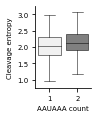


Summary of cleavage entropy by AATAAA count:
              count      mean    median       std
count_aataaa                                     
1              1493  2.015465  2.028845  0.382433
2              1493  2.130513  2.130081  0.373702

Wilcoxon rank-sum test comparing the entropy of sequences with 2 vs 1 AATAAA:
RanksumsResult(statistic=-7.610442705641382, pvalue=2.731586390762787e-14)


In [14]:
dt_count2 = mpra_bog_sel.loc[(mpra_bog_sel['dist_aataaa'].between(18,69)) & (mpra_bog_sel['count_aataaa'] == 2)]
dt_count1 = mpra_bog_sel.loc[(mpra_bog_sel['count_aataaa'] == 1)].sample(n = len(dt_count2), replace = False, random_state = 1234)

mpra_bog_samp = pd.concat([dt_count1, dt_count2], ignore_index = True, sort = False)


fig,ax = plt.subplots(1,1, figsize = (1,1.5))

sns.boxplot(data = mpra_bog_samp, x = 'count_aataaa', y = 'observed_ent', order = [1,2], 
            hue = 'count_aataaa', color = 'gray', dodge = False, hue_order = [1,2],
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black', 'markersize' : 1}, 
            showfliers = False, ax = ax)

ax.set_xlabel("AAUAAA count")
ax.set_ylabel("Cleavage entropy")
ax.set_ylim(0.75,3.25)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend().remove()

plt.savefig(os.path.join(OUTDIR, f'cleavage_entropy_validation.bogard.entropy_by_aauaaa_count.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("\nSummary of cleavage entropy by AATAAA count:")
print(mpra_bog_samp.groupby('count_aataaa')['observed_ent'].agg(['count','mean','median','std']))

print("\nWilcoxon rank-sum test comparing the entropy of sequences with 2 vs 1 AATAAA:")
print(st.ranksums(mpra_bog_samp.loc[mpra_bog_samp['count_aataaa'] == 1, 'observed_ent'],
                  mpra_bog_samp.loc[mpra_bog_samp['count_aataaa'] == 2, 'observed_ent']))


## Second mechanism: CPSF-CstF binding motif distance

In [15]:
mpra_bog_single = mpra_bog_sel.loc[mpra_bog_sel['count_aataaa'] == 1].copy()
mpra_bog_single['idx_trich']  = mpra_bog_single.apply(lambda row: int(75+row['observed_idx']) + classification_cleavage.count_motifs(row['seq_ext'][int(75+row['observed_idx']):min([len(row['seq_ext']),int(75+row['observed_idx']+120)])], t_rich, method = 'sequential', preference = 'min', overlapping = False, count_only = False, index_only = True), axis = 1)
mpra_bog_single['idx_gtrich'] = mpra_bog_single.apply(lambda row: int(75+row['observed_idx']) + classification_cleavage.count_motifs(row['seq_ext'][int(75+row['observed_idx']):min([len(row['seq_ext']),int(75+row['observed_idx']+120)])], gt_rich, method = 'sequential', preference = 'min', overlapping = False, count_only = False, index_only = True), axis = 1)
print(mpra_bog_single.shape)

mpra_bog_long = mpra_bog_single.copy()
mpra_bog_long = mpra_bog_long.explode('idx_aataaa')
mpra_bog_long = mpra_bog_long.explode('idx_trich')
mpra_bog_long = mpra_bog_long.explode('idx_gtrich')
print(mpra_bog_long.shape)


(17378, 32)
(45741, 32)


In [16]:
mpra_bog_long['dist_trich']  = (mpra_bog_long['idx_trich']  - mpra_bog_long['idx_aataaa']).astype(float)
mpra_bog_long['dist_gtrich'] = (mpra_bog_long['idx_gtrich'] - mpra_bog_long['idx_aataaa']).astype(float)


In [17]:
mpra_bog_long['aataaa_between_trich']  = mpra_bog_long.apply(lambda row: classification_cleavage.count_motifs(row['seq_ext'][int(row['idx_aataaa']+6):int(row['idx_trich'])],  ['AATAAA'], method = 'priority', overlapping = False, preference = 'max', count_only = True) if (not np.isnan(row['idx_trich'])) else np.nan, axis = 1)
mpra_bog_long['aataaa_between_gtrich'] = mpra_bog_long.apply(lambda row: classification_cleavage.count_motifs(row['seq_ext'][int(row['idx_aataaa']+6):int(row['idx_gtrich'])], ['AATAAA'], method = 'priority', overlapping = False, preference = 'max', count_only = True) if (not np.isnan(row['idx_gtrich'])) else np.nan, axis = 1)

mpra_bog_long['pas_between_trich']     = mpra_bog_long.apply(lambda row: classification_cleavage.count_motifs(row['seq_ext'][int(row['idx_aataaa']+6):int(row['idx_trich'])],  pas, method = 'priority', overlapping = False, preference = 'max', count_only = True) if (not np.isnan(row['idx_trich'])) else np.nan, axis = 1)
mpra_bog_long['pas_between_gtrich']    = mpra_bog_long.apply(lambda row: classification_cleavage.count_motifs(row['seq_ext'][int(row['idx_aataaa']+6):int(row['idx_gtrich'])], pas, method = 'priority', overlapping = False, preference = 'max', count_only = True) if (not np.isnan(row['idx_gtrich'])) else np.nan, axis = 1)

mpra_bog_long['trich_between_trich']   = mpra_bog_long.apply(lambda row: classification_cleavage.count_motifs(row['seq_ext'][int(row['idx_aataaa']+6):int(row['idx_trich'])],  t_rich, method = 'priority', overlapping = False, preference = 'max', count_only = True) if (not np.isnan(row['idx_trich'])) else np.nan, axis = 1)
mpra_bog_long['trich_between_gtrich']  = mpra_bog_long.apply(lambda row: classification_cleavage.count_motifs(row['seq_ext'][int(row['idx_aataaa']+6):int(row['idx_gtrich'])], t_rich, method = 'priority', overlapping = False, preference = 'max', count_only = True) if (not np.isnan(row['idx_gtrich'])) else np.nan, axis = 1)

mpra_bog_long['gtrich_between_trich']  = mpra_bog_long.apply(lambda row: classification_cleavage.count_motifs(row['seq_ext'][int(row['idx_aataaa']+6):int(row['idx_trich'])],  gt_rich, method = 'priority', overlapping = False, preference = 'max', count_only = True) if (not np.isnan(row['idx_trich'])) else np.nan, axis = 1)
mpra_bog_long['gtrich_between_gtrich'] = mpra_bog_long.apply(lambda row: classification_cleavage.count_motifs(row['seq_ext'][int(row['idx_aataaa']+6):int(row['idx_gtrich'])], gt_rich, method = 'priority', overlapping = False, preference = 'max', count_only = True) if (not np.isnan(row['idx_gtrich'])) else np.nan, axis = 1)


#### Visualize impact of AAUAAA - U-rich distances on clevage heterogeneity

In [19]:
## Require that there are no intervening CPSF or CSTF binding motifs
cond1 = (mpra_bog_long['aataaa_between_trich'] == 0)
cond2 = (mpra_bog_long['pas_between_trich'] == 0)
cond3 = (mpra_bog_long['trich_between_trich'] == 0)
cond4 = (mpra_bog_long['gtrich_between_trich'] == 0)

mpra_bog_long1 = mpra_bog_long.loc[cond1 & cond2 & cond3 & cond4].copy()

print(mpra_bog_long.shape)
print(mpra_bog_long1.shape)


(45741, 42)
(1828, 42)


In [19]:
## Remove duplicates due to multiple CPSF or CSTF binding motifs
mpra_bog_long2 = mpra_bog_long1.drop_duplicates(subset = ['sequence','observed_idx','observed_ent','idx_aataaa','idx_gtrich','dist_gtrich'])
print(mpra_bog_long2.shape)


(1194, 42)


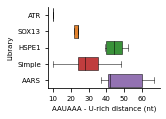


Corresponding sequence counts:
Simple    1059
AARS       111
SOX13        9
HSPE1        8
ATR          7
Name: library_name, dtype: int64


In [20]:
## Remove sequences from libraries with few sequences or no/low variance in AAUAAA - U-rich distances

fig,ax = plt.subplots(1,1, figsize = (2,1.5))

sns.boxplot(data = mpra_bog_long2, x = 'dist_trich', y = 'library_name', 
            order = ['ATR','SOX13','HSPE1','Simple','AARS'],
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black', 'markersize' : 1}, 
            showfliers = False, ax = ax)

ax.set_xlabel("AAUAAA - U-rich distance (nt)")
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.set_ylabel("Library")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()


print("\nCorresponding sequence counts:")
print(mpra_bog_long2['library_name'].value_counts())


In [21]:
mpra_bog_long3 = mpra_bog_long2.loc[mpra_bog_long2['library_name'].isin(['AARS','Simple'])].copy()
print(mpra_bog_long3.shape)


(1170, 42)


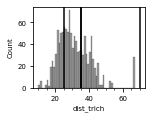

25-35    477
35-70    383
Name: plot_bin, dtype: int64


In [22]:
## Split sequences into "close" and "far" bins based on AAUAAA - GU/CU-rich distance

low1,high1 = (25,35)
low2,high2 = (35,70)

plot_data = mpra_bog_long3.copy()

fig,ax = plt.subplots(1,1, figsize = (2,1.5))
sns.histplot(data = plot_data, x = 'dist_trich', color = 'gray', binwidth = 1)
for x in (low1,high1,low2,high2): ax.axvline(x = x, color = 'black')
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(5))
plt.show()

plot_data['plot_bin'] = np.nan
plot_data.loc[plot_data['dist_trich'].between(low1,high1), 'plot_bin'] = f'{low1}-{high1}'
plot_data.loc[plot_data['dist_trich'].between(low2,high2), 'plot_bin'] = f'{low2}-{high2}'
print(plot_data['plot_bin'].value_counts())


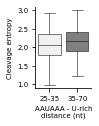


Summary of cleavage entropy by group:
          count      mean    median       std
plot_bin                                     
25-35       477  2.056545  2.067102  0.417803
35-70       383  2.163974  2.177939  0.373987

Wilcoxon rank-sum test comparing the cleavage entropy:
RanksumsResult(statistic=-3.6916088718783318, pvalue=0.00022283997098986594)


In [23]:
## Visualize cleavage entropy by AAUAAA - U-rich distance

fig,ax = plt.subplots(1,1, figsize = (1,1.5))

sns.boxplot(data = plot_data, x = 'plot_bin', y = 'observed_ent', order = [f'{low1}-{high1}',f'{low2}-{high2}'], 
            hue = 'plot_bin', color = 'gray', dodge = False, hue_order = [f'{low1}-{high1}',f'{low2}-{high2}'], 
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black', 'markersize' : 1}, 
            showfliers = False, ax = ax)

ax.set_xlabel("AAUAAA - U-rich\ndistance (nt)")

ax.set_ylabel("Cleavage entropy")
ax.yaxis.set_major_locator(MultipleLocator(0.5))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend().remove()

plt.savefig(os.path.join(OUTDIR, f'cleavage_entropy_validation.bogard.entropy_by_aauaaa-urich-distance.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("\nSummary of cleavage entropy by group:")
print(plot_data.groupby('plot_bin')['observed_ent'].agg(['count','mean','median','std']))

print("\nWilcoxon rank-sum test comparing the cleavage entropy:")
print(st.ranksums(plot_data.loc[plot_data['plot_bin'] == f'{low1}-{high1}', 'observed_ent'],
                  plot_data.loc[plot_data['plot_bin'] == f'{low2}-{high2}', 'observed_ent']))


In [24]:
print("Close:")

for i,row in plot_data.loc[plot_data['plot_bin'] == f'{low1}-{high1}'].sample(n = 10, replace = False, random_state = 1234).iterrows():
    
    seq1 = row['seq_ext'][:row['idx_aataaa']]
    seq2 = row['seq_ext'][row['idx_aataaa']:int(row['idx_aataaa']+6)]
    seq3 = row['seq_ext'][int(row['idx_aataaa']+6):int(row['idx_trich'])]
    seq4 = row['seq_ext'][int(row['idx_trich']):int(row['idx_trich']+6)]
    seq5 = row['seq_ext'][int(row['idx_trich']+6):]
    
    print(i, "\t", " ".join([seq1,seq2,seq3,seq4,seq5]))

print("Far:")

for i,row in plot_data.loc[plot_data['plot_bin'] == f'{low2}-{high2}'].sample(n = 10, replace = False, random_state = 1234).iterrows():
    
    seq1 = row['seq_ext'][:row['idx_aataaa']]
    seq2 = row['seq_ext'][row['idx_aataaa']:int(row['idx_aataaa']+6)]
    seq3 = row['seq_ext'][int(row['idx_aataaa']+6):int(row['idx_trich'])]
    seq4 = row['seq_ext'][int(row['idx_trich']):int(row['idx_trich']+6)]
    seq5 = row['seq_ext'][int(row['idx_trich']+6):]
    
    print(i, "\t", " ".join([seq1,seq2,seq3,seq4,seq5]))


Close:
1430327 	 ACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTCTTGATCCCTACACGACGCTCTTCCGATCTTGTTTACTCGGGTTTTGCTTTAGTGACTTACAATTTGTGCAGAGA AATAAA ATATGGTTATCTAAAAAGC TTTTTG GTCTCTTTGCTGTACTTAGTATTAAACACTCATCTGAGGTTGGCGGGGGCTTAAATAGAAGCAGAACTCTGCGCCTAACCCTAAGCAGATTCTTCATGCA
1449394 	 ACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTCTTGATCCCTACACGACGCTCTTCCGATCTTTATCTGGGGGCGATTTTATGTATCTGTCATGTATTGTTACTTTG AATAAA TATGAGATGGTGAAGAGCCTTTTCCC TTTTTC TAATTGTTTTGCTATTAAAGTTGCTTGGGAAGCCGTCTAGGCCGTCTGCGGTTTGGTCATGAGTCGCCTAACCCTAAGCAGATTCTTCATGCA
1449760 	 ACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTCTTGATCCCTACACGACGCTCTTCCGATCTTTCTTAGACAGGAGGTGCCTGATGAGAATATTGATTTCTTTTATAATTAAATTCACGCTTAACTAGACACTGAGCTCTGTATTTGGATTGTTGGCT AATAAA ACTCACTTTGCCTTGATGA TTTTTC CTGTACTCTTGTGGCAGGGACGCCTAACCCTAAGCAGATTCTTCATGCA
1439458 	 ACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTCTTGATCCCTACACGACGCTCTTCCGATCTGCTCTATAGATCTTGTTAATGGCTCTTTGTAATTAGAATTGCTTA AATAAA GGCATATGGAATTTCACTGAG TTTTTG TTAAGGCT

#### Visualize impact of AAUAAA - GU/CU-rich distances on clevage heterogeneity

In [23]:
## Require that there are no intervening CPSF or CSTF binding motifs
cond1 = (mpra_bog_long['aataaa_between_gtrich'] == 0)
cond2 = (mpra_bog_long['pas_between_gtrich'] == 0)
cond3 = (mpra_bog_long['trich_between_gtrich'] == 0)
cond4 = (mpra_bog_long['gtrich_between_gtrich'] == 0)

mpra_bog_long1 = mpra_bog_long.loc[cond1 & cond2 & cond3 & cond4].copy()
print(mpra_bog_long.shape)
print(mpra_bog_long1.shape)


(45741, 42)
(13556, 42)


In [25]:
## Remove duplicates due to multiple CPSF or CSTF binding motifs
mpra_bog_long2 = mpra_bog_long1.drop_duplicates(subset = ['sequence','observed_idx','observed_ent','idx_aataaa','idx_gtrich','dist_gtrich'])
print(mpra_bog_long2.shape)


(6438, 42)


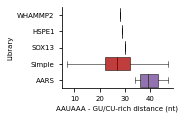


Corresponding sequence counts:
HSPE1      5022
Simple     1236
WHAMMP2     107
SOX13        48
AARS         25
Name: library_name, dtype: int64


In [27]:
## Remove sequences from libraries with few sequences or no/low variance in AAUAAA - GU/CU-rich distances

fig,ax = plt.subplots(1,1, figsize = (2,1.5))

sns.boxplot(data = mpra_bog_long2, x = 'dist_gtrich', y = 'library_name', 
            order = ['WHAMMP2','HSPE1','SOX13','Simple','AARS'],
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black', 'markersize' : 1}, 
            showfliers = False, ax = ax)

ax.set_xlabel("AAUAAA - GU/CU-rich distance (nt)")
ax.set_ylabel("Library")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()


print("\nCorresponding sequence counts:")
print(mpra_bog_long2['library_name'].value_counts())


In [28]:
mpra_bog_long3 = mpra_bog_long2.loc[mpra_bog_long2['library_name'].isin(['AARS','Simple'])].copy()
print(mpra_bog_long3.shape)


(1261, 42)


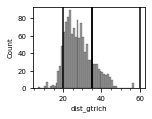

In [29]:
## Split sequences into "close" and "far" bins based on AAUAAA - GU/CU-rich distance

low1,high1 = (20,35)
low2,high2 = (35,60)

plot_data = mpra_bog_long3.copy()

fig,ax = plt.subplots(1,1, figsize = (2,1.5))
sns.histplot(data = plot_data, x = 'dist_gtrich', color = 'gray', binwidth = 1)
for x in (low1,high1,low2,high2): ax.axvline(x = x, color = 'black')
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(5))
plt.show()

plot_data['plot_bin'] = np.nan
plot_data.loc[plot_data['dist_gtrich'].between(low1,high1), 'plot_bin'] = f'{low1}-{high1}'
plot_data.loc[plot_data['dist_gtrich'].between(low2,high2), 'plot_bin'] = f'{low2}-{high2}'


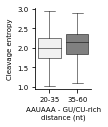


Summary of cleavage entropy by group:
          count      mean    median       std
plot_bin                                     
20-35       923  1.982962  2.007950  0.375462
35-60       222  2.097661  2.147811  0.369611

Wilcoxon rank-sum test comparing the cleavage entropy:
RanksumsResult(statistic=-4.048708992930955, pvalue=5.150093309999438e-05)


In [30]:
## Visualize cleavage entropy by AAUAAA - GU/CU-rich distance

fig,ax = plt.subplots(1,1, figsize = (1,1.5))

sns.boxplot(data = plot_data, x = 'plot_bin', y = 'observed_ent', order = [f'{low1}-{high1}',f'{low2}-{high2}'], 
            hue = 'plot_bin', color = 'gray', dodge = False, hue_order = [f'{low1}-{high1}',f'{low2}-{high2}'],
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black', 'markersize' : 1}, 
            showfliers = False, ax = ax)

ax.set_xlabel("AAUAAA - GU/CU-rich\ndistance (nt)")

ax.set_ylabel("Cleavage entropy")
ax.yaxis.set_major_locator(MultipleLocator(0.5))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend().remove()

plt.savefig(os.path.join(OUTDIR, f'cleavage_entropy_validation.bogard.entropy_by_aauaaa-gucurich-distance.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("\nSummary of cleavage entropy by group:")
print(plot_data.groupby('plot_bin')['observed_ent'].agg(['count','mean','median','std']))

print("\nWilcoxon rank-sum test comparing the cleavage entropy:")
print(st.ranksums(plot_data.loc[plot_data['plot_bin'] == f'{low1}-{high1}', 'observed_ent'],
                  plot_data.loc[plot_data['plot_bin'] == f'{low2}-{high2}', 'observed_ent']))


In [31]:
print("Close:")

for i,row in plot_data.loc[plot_data['plot_bin'] == f'{low1}-{high1}'].sample(n = 10, replace = False, random_state = 1234).iterrows():
    
    seq1 = row['seq_ext'][:row['idx_aataaa']]
    seq2 = row['seq_ext'][row['idx_aataaa']:int(row['idx_aataaa']+6)]
    seq3 = row['seq_ext'][int(row['idx_aataaa']+6):int(row['idx_gtrich'])]
    seq4 = row['seq_ext'][int(row['idx_gtrich']):int(row['idx_gtrich']+6)]
    seq5 = row['seq_ext'][int(row['idx_gtrich']+6):]
    
    print(i, "\t", " ".join([seq1,seq2,seq3,seq4,seq5]))

print("Far:")

for i,row in plot_data.loc[plot_data['plot_bin'] == f'{low2}-{high2}'].sample(n = 10, replace = False, random_state = 1234).iterrows():
    
    seq1 = row['seq_ext'][:row['idx_aataaa']]
    seq2 = row['seq_ext'][row['idx_aataaa']:int(row['idx_aataaa']+6)]
    seq3 = row['seq_ext'][int(row['idx_aataaa']+6):int(row['idx_gtrich'])]
    seq4 = row['seq_ext'][int(row['idx_gtrich']):int(row['idx_gtrich']+6)]
    seq5 = row['seq_ext'][int(row['idx_gtrich']+6):]
    
    print(i, "\t", " ".join([seq1,seq2,seq3,seq4,seq5]))


Close:
1425453 	 ACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTCTTGATCCCTACACGACGCTCTTCCGATCTTTCTTTAACGAGGGATTGCTGTTGCTTACTGTTGTCTTTGTTGAGATTAAATAGAGCAATTTGCTGTTTAATCAGGTTTATTTCAAGAGTAGTAAT AATAAA TTCACGTCAAGTCC TATGTG GGCCTTTTTTTTAGTGTTGAAATCGCGCCTAACCCTAAGCAGATTCTTCATGCA
1426390 	 ACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTCTTGATCCCTACACGACGCTCTTCCGATCTGAGTCTATTTAAAATGAAGGCATGGTCGTGCCATTGGACACTCCC AATAAA AAATGGAGCTAAATTT TCCTGT TAATACTTGCATTTCTTTAAACAATTAAATGTCATGTAGTTTTTGTTCCTCTGTAGGGATTGCTGCTATGCCGCCGCCTAACCCTAAGCAGATTCTTCATGCA
1376954 	 ACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTCTTGATCCCTACACGACGCTCTTCCGATCTAGTGGGATCGTATGGAATACTTCAGCTATCTAATGTGTAGCTAGCATTAAAAAAGATTTTCTCTGTAGTTTGGGAAGTGGTATCTGGGGGTTCTGT AATAAA GTTTGCTGCATCAGTGGAAGG GGGTGT TCCTTCGGTTCTATTGCCCGCCTAACCCTAAGCAGATTCTTCATGCA
1457247 	 ACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTCTTGATCCCTACACGACGCTCTTCCGATCTAGAAAGAAGGTAAACATGTTAATGCATCTAAGTTCAAAGTTACAC AATAAA GAGGCCGAGTTCTCACAAAAGGT TTTGTG GTTGTG